## Read CSVs

In [159]:
!ls

EDA.ipynb              t_change_report.html   t_people_report.html
LICENSE                t_file_report.html     t_revision_report.html
csv_files              t_history_report.html


In [ ]:
# to download the data go to https://kin-y.github.io/miningReviewRepo/

In [160]:
import pandas as pd

In [161]:
t_file = pd.read_csv("csv_files/t_file.csv")
t_people = pd.read_csv("csv_files/t_people.csv")
t_change = pd.read_csv("csv_files/t_change.csv")
t_history = pd.read_csv("csv_files/t_history.csv")
t_revision = pd.read_csv("csv_files/t_revision.csv")

In [162]:
print("shape of t_file : {}".format(t_file.shape))
print("shape of t_people : {}".format(t_people.shape))
print("shape of t_change : {}".format(t_change.shape))
print("shape of t_history : {}".format(t_history.shape))
print("shape of t_revision : {}".format(t_revision.shape))

shape of t_file : (1490072, 5)
shape of t_people : (2534, 5)
shape of t_change : (57376, 12)
shape of t_history : (435814, 7)
shape of t_revision : (106957, 15)


## Dtypes setup

In [95]:
# use pandas to_datetime function to convert the string datatype to datetime
t_change.ch_createdTime = pd.to_datetime(t_change.ch_createdTime)
t_change.ch_updatedTime = pd.to_datetime(t_change.ch_updatedTime)

## Import CSV into local in-memory sqlite server

In [163]:
# use sqlalchemy to create a local sqlite engine and connect it to the notebook. 

from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
engine.connect

<bound method Engine.connect of Engine(sqlite://)>

In [164]:
# use pandas to_sql function to convert the dataframe into a sql table

t_file.to_sql("t_file", con= engine, if_exists='replace', index=False)
t_people.to_sql("t_people", con= engine, if_exists='replace', index=False)
t_change.to_sql("t_change", con= engine, if_exists='replace', index=False)
t_history.to_sql("t_history", con= engine, if_exists='replace', index=False)
t_revision.to_sql("t_revision", con= engine, if_exists='replace', index=False)

#### tables in the database

In [165]:
# get all the table names in the engine
engine.table_names()

<ipython-input-165-d72bc75a6b62>:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['t_change', 't_file', 't_history', 't_people', 't_revision']

#### Schema

In [166]:
# display the schema diagram

from IPython.display import Image
Image(url='https://image.slidesharecdn.com/msr16yang-160515235151/95/msr-2016-data-showcase-mining-code-review-repositories-11-638.jpg?cb=1463356751') 

#### Query syntax

In [167]:
use pandas sql method to read sql queries on the engine. 


pd.read_sql(
"""
SELECT * FROM t_revision 
;
""", con= engine).head(2)

# note that the output is a pandas dataframe and can be object referenced 

# t_revision_sql_result = pd.read_sql(
# """
# SELECT * FROM t_revision 
# ;
# """, con= engine).head(2)

,id,rev_id,rev_subject,rev_message,rev_authorUsername,rev_createdTime,rev_committerUsername,rev_committedTime,rev_ref,rev_git,rev_repo,rev_http,rev_ssh,rev_patchSetNum,rev_changeId
0,1,663dd192a19e7ab1452668a3672fb467c8110e04,Add IP subnet utility method for converting lists,Add IP subnet utility method for converting li...,Alex Bikfalvi,2016-11-17 15:18:15,Alex Bikfalvi,2016-11-17 21:59:31,refs/changes/81/302681/1,None,None,https://review.gerrithub.io/midonet/midonet,None,1,1
1,2,fc9090c70665a19c44037113d5e3631e2c238aa8,Make FlowRecorder send records over TCP to Clio.,Make FlowRecorder send records over TCP to Cli...,Alexandre Fonseca,2016-11-18 11:18:02,Alexandre Fonseca,2016-11-18 11:19:30,refs/changes/12/302712/1,None,None,https://review.gerrithub.io/midonet/midonet,None,1,2


## What percentage of code reviews gets merged?

In [106]:
merged_ = pd.read_sql("""
SELECT 
ch_project,
count(*) as total_changes, 
sum(case when ch_status = 'MERGED' then 1 else 0 end) as Total_Merged,
sum(case when ch_status = 'ABANDONED' then 1 else 0 end) as Total_abandoned
from (SELECT distinct 
ch_project
, ch_branch
, ch_topic
, ch_authorAccountId
, ch_createdTime
, ch_updatedTime
, ch_status

FROM t_change) 
group by 1;

""", con = engine)

In [107]:
merged_['pct_merged'] = merged_['Total_Merged'] / merged_['total_changes'] * 100
merged_['pct_abandoned'] = merged_['Total_abandoned'] / merged_['total_changes'] * 100

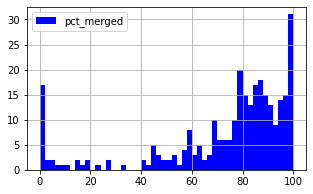

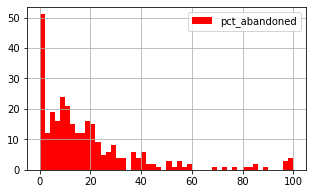

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

merged_[merged_['total_changes'] > 20].pct_merged.hist(bins = 50
                                                       , color = 'b'
                                                       , figsize = (5,3)
                                                       , legend = True)
plt.show()

merged_[merged_['total_changes'] > 20].pct_abandoned.hist(bins = 50
                                                          , color = 'r'
                                                          , figsize = (5,3)
                                                          , legend = True)
plt.show()

### Result

In [175]:
print("Average percent merged " + str(round(merged_[merged_['total_changes'] > 20].pct_merged.mean(), 2)) + "%")
print("Median percent merged " + str(round(merged_[merged_['total_changes'] > 20].pct_merged.median(), 2)) + "%")

print("------------------------")

print("Average percent abandoned " + str(round(merged_[merged_['total_changes'] > 20].pct_abandoned.mean(), 2)) + "%")
print("Median percent abandoned " + str(round(merged_[merged_['total_changes'] > 20].pct_abandoned.median(), 2)) + "%")

Average percent merged 73.05%
Median percent merged 81.89%
------------------------
Average percent abandoned 18.94%
Median percent abandoned 12.5%


## How long does it take to get a code review merged?

In [194]:
merged_time_ = pd.read_sql("""
SELECT 
ch_project
, ch_branch
, ch_topic
, case when ch_status = 'MERGED' then min(ch_createdTime) else 0 end as first_ch_createdTime
, case when ch_status = 'MERGED' then max(ch_updatedTime) else 0 end as last_ch_updatedTime
, count(*) as total_changes

from (SELECT distinct 
ch_project
, ch_branch
, ch_topic
, ch_authorAccountId
, ch_createdTime
, ch_updatedTime
, ch_status

FROM t_change) 
group by 1, 2, 3;

""", con = engine)

In [195]:
merged_time_['first_ch_createdTime'] = pd.to_datetime(merged_time_.first_ch_createdTime)
merged_time_['last_ch_updatedTime'] = pd.to_datetime(merged_time_.last_ch_updatedTime)


In [200]:
merged_time_['time_to_merge'] = (merged_time_.last_ch_updatedTime - merged_time_.first_ch_createdTime).dt.total_seconds() / 60 / 60 / 24

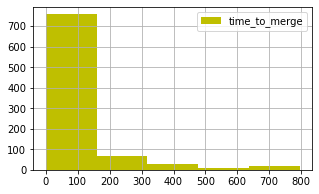

In [201]:
merged_time_[merged_time_['total_changes'] > 5].time_to_merge.hist(bins = 5
                                                          , color = 'y'
                                                          , figsize = (5,3)
                                                          , legend = True)
plt.show()

### Result

### Where total project changes are <= 10 

In [202]:
print("Average time to get merged " 
      + str(round(merged_time_[merged_time_['total_changes'] <= 10].time_to_merge.mean(), 2)) 
      + " days")
print("Median time to get merged " 
      + str(round(merged_time_[merged_time_['total_changes'] <= 10].time_to_merge.median(), 2)) 
      + " days")

Average time to get merged 7.09 days
Median time to get merged 0.11 days


### Where total project changes are > 10 

In [203]:
print("Average time to get merged " 
      + str(round(merged_time_[merged_time_['total_changes'] > 10].time_to_merge.mean(), 2)) 
      + " days")
print("Median time to get merged " 
      + str(round(merged_time_[merged_time_['total_changes'] > 10].time_to_merge.median(), 2)) 
      + " days")

Average time to get merged 87.63 days
Median time to get merged 7.25 days
